In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

In [3]:
tourney_data = pd.read_csv("../data/processed/tourney_data.csv")

In [4]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_AdjD,T2_AdjT,T2_Luck,T2_Strength of Schedule_AdjEM,T2_Strength of Schedule_OppO,T2_Strength of Schedule_OppD,T2_NCSOS_AdjEM,T1_seed,T2_seed,SeedDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,108.7,68.4,0.037,-12.96,94.4,107.4,-8.09,16,16,0
1,2003,134,1411,84,1421,92,0,1,29,67,...,113.5,68.0,0.119,-6.45,98.3,104.7,11.61,16,16,0
2,2003,136,1436,51,1112,80,0,0,20,64,...,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,16,1,15
3,2003,136,1112,80,1436,51,0,0,31,66,...,99.5,64.4,0.019,-5.14,99.3,104.4,-2.29,1,16,-15
4,2003,136,1113,84,1272,71,0,0,31,59,...,94.1,68.3,0.005,4.83,103.4,98.6,3.33,10,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,152,1403,61,1277,51,0,0,22,51,...,90.2,66.9,0.001,13.67,110.6,96.9,3.24,3,2,1
2226,2019,152,1120,62,1438,63,0,0,21,55,...,89.2,59.4,0.050,11.18,109.2,98.1,-3.24,5,1,4
2227,2019,152,1438,63,1120,62,0,0,25,51,...,95.9,67.9,0.008,12.23,110.7,98.5,2.63,1,5,-4
2228,2019,154,1438,85,1403,77,0,1,27,59,...,84.1,66.6,0.004,11.18,109.8,98.7,-5.39,1,3,-2


# Model Building

In [47]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [24]:
features = [
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
       'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
       'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
       'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
       'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
       'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
       'SeedDiff'
]

features2 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
   'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
   'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
   'SeedDiff'
]

In [25]:
features3 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 
   'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 
    'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 
   'SeedDiff'
]

features4 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 
   'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_AdjEM',
   'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
   'SeedDiff'
]

In [8]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

# Model Building Pipeline

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import linear_model
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

def reg_cv_train(features, 
                 estimator, 
                 mode='reg', 
                 plot=False, 
                 verbose=False,
                 test_df=None
                ):
    preds_test=None
    # get full dataset:
    df = tourney_data.dropna(how='any').reset_index().copy()

    # split X and y:
    X = df[features]
    y = np.where(df['PointDiff'] > 0, 1, 0)

    # use leave-one-group-out:
    logo = LeaveOneGroupOut()
    groups = df['Season']

    cvs = []

    for i , (train_ix, val_ix) in enumerate(logo.split(X, y, groups)):
        # split data:
        X_train = X.iloc[train_ix]
        y_train = y[train_ix]
        X_val = X.iloc[val_ix]
        y_val = y[val_ix]


        # fit pipeline:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.85)),
            ('estimator', estimator)
        ])

        pipe.fit(X_train, y_train)

        # predict values:
        if mode == "reg":
            pred = pipe.predict(X_val)
            pred = np.clip(pred, 0, 1) # because regression
            if test_df is not None:
                preds_test = pipe.predict(test_df[features])
                preds_test = np.clip(preds_test, 0, 1)
        else:
            pred = pipe.predict_proba(X_val)[:, 1]
            if test_df is not None:
                preds_test = pipe.predict_proba(test_df[features])[:, 1]
        # plot:
        if plot:
            plt.figure(figsize=(15,6))
            plt.subplot(1,2,1)
            plt.scatter(pred, df.loc[val_ix, 'PointDiff'], s=5)
            plt.subplot(1,2,2)
            sns.histplot(pred)
            plt.show()

        # loss:
        loss = log_loss(y_val, pred)
        cvs.append(loss)

        if verbose: print(f"{i+min(groups)} Loss : {loss}")
    
    plt.figure()
    plt.plot(range(min(groups), min(groups) + len(set(groups))), cvs)
    plt.xlabel("Year")
    plt.ylabel("Log Loss")

    print(f"Local CV Loss : {np.mean(cvs):.3f}  -----  {e.__class__.__name__}")
    return np.mean(cvs), preds_test

# Linear Models

Local CV Loss : 0.526  -----  BayesianRidge
Local CV Loss : 0.527  -----  ARDRegression
Local CV Loss : 0.526  -----  ElasticNetCV
Local CV Loss : 0.610  -----  ElasticNet
Local CV Loss : 0.693  -----  Lasso
Local CV Loss : 0.494  -----  LogisticRegression
Local CV Loss : 0.544  -----  SGDRegressor
Local CV Loss : 0.525  -----  LinearRegression


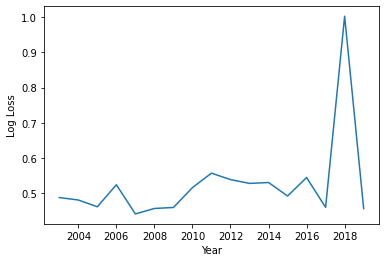

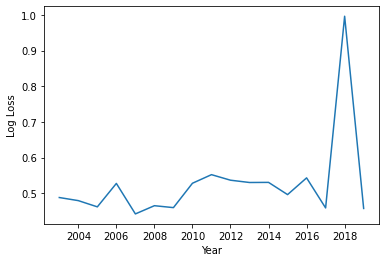

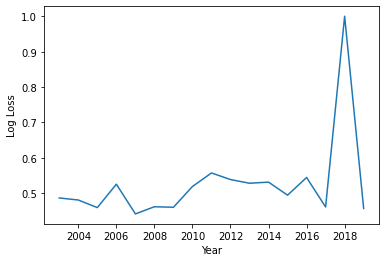

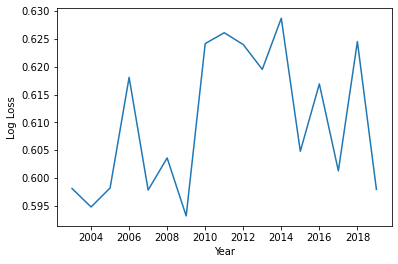

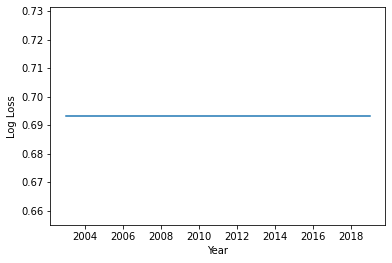

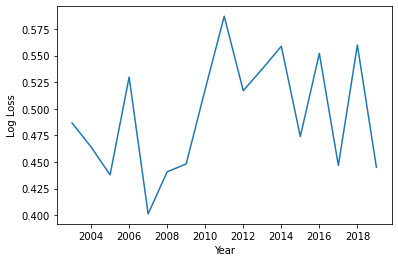

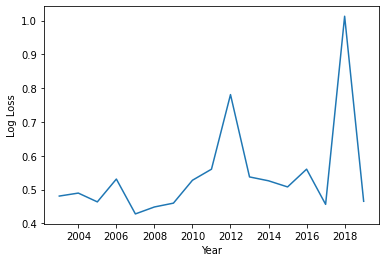

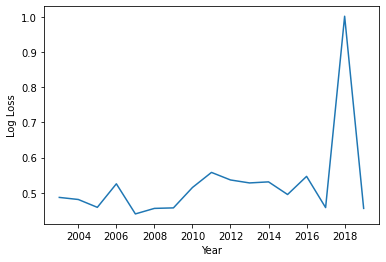

In [42]:
# bulk trial:
estimators = [
    (linear_model.BayesianRidge(), 'reg'),
    (linear_model.ARDRegression(), 'reg'),
    (linear_model.ElasticNetCV(), 'reg'),
    (linear_model.ElasticNet(), 'reg'),
    (linear_model.Lasso(), 'reg'),
    (linear_model.LogisticRegression(), 'cls'),
    (linear_model.SGDRegressor(), 'reg'),
    (linear_model.LinearRegression(), 'reg')
]

scores = {}

for e, mode in estimators:
    scores[e.__class__.__name__] = reg_cv_train(
        features=features, 
        estimator=e,
        mode=mode, 
        plot=False, 
        verbose=False)

# Test Set

In [30]:
from src.features import build_features

test_data = pd.read_csv("../data/external/MSampleSubmissionStage1.csv")
test_data[['Season', 'T1_TeamID', 'T2_TeamID']] = test_data['ID'].str.split("_",expand=True)
for c in ['Season', 'T1_TeamID', 'T2_TeamID']:
    test_data[c] = test_data[c].astype(int)
    
test_data = build_features.build_test_data(test_data)

Local CV Loss : 0.500  -----  LinearRegression


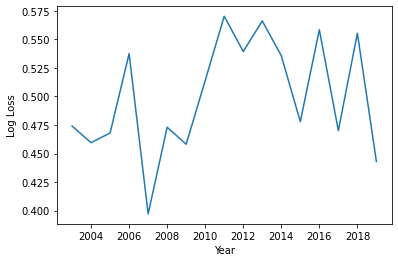

In [46]:
cv_score, test_preds = reg_cv_train(
        features=features4, 
        estimator=linear_model.LogisticRegression(),
        mode='cls', 
        plot=False, 
        verbose=False,
        test_df=test_data
)

<AxesSubplot:ylabel='Count'>

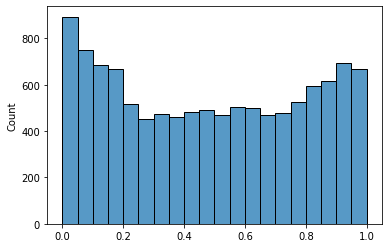

In [33]:
sns.histplot(test_preds)